In [130]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # görüntü işlemleri için
from tensorflow.keras.models import Sequential # kendi oluşturacağımız model için
from tensorflow.keras.layers import Dense # kendi oluşturacağımız model için
from tensorflow.keras.applications.vgg16 import VGG16  # VGG16 Transfer Learning modeli için
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image # Image open, resize image gibi işlemler için
import matplotlib.pyplot as plt
import numpy as np


In [131]:
# train ve test görsellerinin yollarımızı tanımlıyoruz
train_files_path = "airplanedataset/Train/"
test_files_path = "airplanedataset/Test/"


In [132]:
# uçak görüntüleri dizininden test ve train veri kümesini oluşturma
train_data = ImageDataGenerator().flow_from_directory(train_files_path,target_size = (224,224))#VGG16 target size'ı (224,224) kullandığı için bizde böyle seçtik
test_data = ImageDataGenerator().flow_from_directory(test_files_path,target_size = (224,224))


Found 1807 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [133]:
numberOfAirplaneTypes = 5 # 5 farklı uçak tipi kulllanılacak


### Model Oluşturma



In [134]:
# model nesnesi oluşturma
vgg = VGG16()

In [135]:
vgg_layers = vgg.layers #VGG katmanlarını alma
print(vgg_layers)

[<keras.engine.input_layer.InputLayer object at 0x162388250>, <keras.layers.convolutional.Conv2D object at 0x162388100>, <keras.layers.convolutional.Conv2D object at 0x162388d30>, <keras.layers.pooling.MaxPooling2D object at 0x16238be20>, <keras.layers.convolutional.Conv2D object at 0x1623e83d0>, <keras.layers.convolutional.Conv2D object at 0x1623eb3d0>, <keras.layers.pooling.MaxPooling2D object at 0x16238bd30>, <keras.layers.convolutional.Conv2D object at 0x1623eeaf0>, <keras.layers.convolutional.Conv2D object at 0x1623e8970>, <keras.layers.convolutional.Conv2D object at 0x1623f72e0>, <keras.layers.pooling.MaxPooling2D object at 0x1623ee6d0>, <keras.layers.convolutional.Conv2D object at 0x1623e8f10>, <keras.layers.convolutional.Conv2D object at 0x1623ff3d0>, <keras.layers.convolutional.Conv2D object at 0x1624016d0>, <keras.layers.pooling.MaxPooling2D object at 0x1623f7640>, <keras.layers.convolutional.Conv2D object at 0x1623f35e0>, <keras.layers.convolutional.Conv2D object at 0x16240c

In [136]:
vggmodel_layersize_tobe_used = len(vgg_layers) - 1 # -1 ile vgg layerlarının sonundaki output layerını çıkarıyoruz ve layer sayımızı buluyoruz

model = Sequential()# bu layerları oluşturduğumuz boş modele atıyoruz
for i in range(vggmodel_layersize_tobe_used):
    model.add(vgg_layers[i])


In [137]:
# VGG16'dan aldığım layerları train etme : trainable:False
for layers in model.layers:
    layers.trainable = False

# Çıkardığım output layer yerine kendim output layer ekliyorum.
model.add(Dense(numberOfAirplaneTypes, activation="softmax"))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [138]:
# modeli compile ediyoruz
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [139]:
#modeli eğitip başarısını hesaplatıyoruz

batch_size = 4 

model.fit(train_data,
          epochs=20,
          steps_per_epoch=400//batch_size,
          validation_data=test_data,
          validation_steps=200//batch_size)


Epoch 1/20
100/100 [==============================] - 218s 2s/step - loss: 0.6367 - accuracy: 0.8152 - val_loss: 0.1846 - val_accuracy: 0.9100


In [140]:
#Görüntü yükleyip boyutunu VGG16 kullandığımız için 224x224 yapıyoruz
img = Image.open("McDonnellDouglas_kc10.jpg").resize((224,224))

In [141]:
#Görüntüyü array'e çeviriyoruz
img = np.array(img)

In [142]:
img.shape

(224, 224, 3)

In [143]:
print(img.ndim)

3


In [144]:
#Görüntüyü 4 boyutluya çevirmek için -1 
img = img.reshape(-1,224,224,3)   

In [145]:
print(img.shape)
print(img.ndim)

(1, 224, 224, 3)
4


In [146]:
#preprocess_input özelliği ile giriş piksellerini -1 ile 1 arasında ölçeklendiriyoruz. Çünkü VGG16 bunu gerektiriyor.
img = preprocess_input(img)   

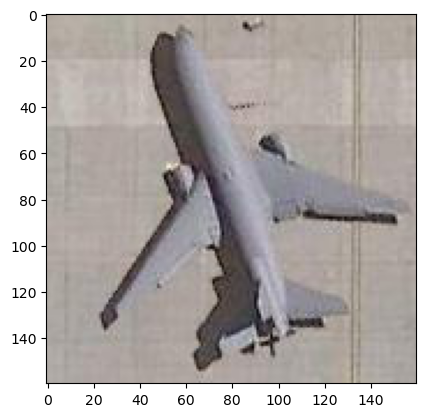

In [147]:
img_for_display = load_img("McDonnellDouglas_kc10.jpg")
plt.imshow(img_for_display)
plt.show()

### Tahmin yaptırma

In [148]:
preds = model.predict(img)


In [149]:
# tahmin arrayi görüntüleme 
preds

array([[2.7926094e-04, 1.5698396e-02, 4.6307928e-04, 3.2388442e-04,
        9.8323536e-01]], dtype=float32)

Her bir çıktının olasılıkları

In [150]:
image_classes = ["A-10 Thunderbolt","Boeing B-52","Boeing E-3 Sentry","F-22 Raptor","KC-10 Extender"]

result = np.argmax(preds[0])
print(image_classes[result]) 

KC-10 Extender
